In [1]:
from openmm import app, unit
import numpy as np
import openmm
import fresnel
import matplotlib.pyplot as plt
from simtk import unit

import sys
# sys.path.append("/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/polychrom")
from polychrom.hdf5_format import HDF5Reporter
from polychrom import forcekits, forces, simulation

from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize, to_rgb
import matplotlib.patches as mpatches

#add local polykit to path
# sys.path.append("/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/utilis/polykit")
import polykit.polykit.renderers.backends as backends
from polykit.polykit.generators.initial_conformations import grow_cubic, create_random_walk
import polykit as polykit

from polychrom.lib.extrusion import bondUpdater

from polychrom.forces import heteropolymer_SSW

## Example of strange behavior

When modeling a 10-mer, you get EKExceeds error with usual collision rate of 0.06
Pushing collision rate up to 1 fixes error...

I don't define a reporter, so trajectories do not save.

In [4]:
def get_bonds(sim_object, chains=[(0, None, False)], extra_bonds=None):
    """
    Generates a list of bonds connecting polymer chains and returns them as an Mx2 int array.

    Parameters
    ----------
    sim_object : Simulation
        The simulation object containing the particles. Assumes sim_object.N is the number of particles.
    chains : list of tuples, optional
        The list of chains in the format [(start, end, isRing)]. The particle range is semi-open, 
        i.e., a chain (0, 3, False) links particles 0, 1, and 2. If isRing is True, then the first
        and last particles of the chain are linked into a ring.
        The default value links all particles of the system into one chain.
    extra_bonds : list of tuples, optional
        Additional bonds to add. Each tuple should be (particle1, particle2).

    Returns
    -------
    bonds : np.ndarray of shape (M, 2)
        An array of bonds, where each row is a bond represented as (particle1, particle2).
    """
    # Start with extra bonds if provided, otherwise an empty list
    bonds_list = [] if (extra_bonds is None or len(extra_bonds) == 0) else [tuple(b) for b in extra_bonds]

    for start, end, is_ring in chains:
        # If end is None, use total number of particles in sim_object
        end = sim_object.N if (end is None) else end

        # Add consecutive bonds within the chain
        bonds_list.extend([(j, j + 1) for j in range(start, end - 1)])

        # If the chain is a ring, add a bond connecting the last to the first particle
        if is_ring:
            bonds_list.append((start, end - 1))
    
    # Convert list of tuples to a NumPy array with integer type
    bonds = np.array(bonds_list, dtype=int)
    return bonds  

def get_triplets(sim_object, chains=[(0, None, False)], extra_triplets=None):
    """
    Generates a list of triplets connecting polymer chains and returns them as an Mx3 int array.
    e.g., if bonds are [(0,1), (1,2), (2,3), (3,4), (4,5)]
    then triplets are [(0,1,2), (1,2,3), (2,3,4), (3,4,5)]
    if it is a ring, then the last triplet is (4,5,0)

    Parameters
    ----------
    sim_object : Simulation
        The simulation object containing the particles. Assumes sim_object.N is the number of particles.
    chains : list of tuples, optional
        The list of chains in the format [(start, end, isRing)]. The particle range is semi-open, 
        i.e., a chain (0, 3, False) links particles 0, 1, and 2. If isRing is True, then the first
        and last particles of the chain are linked into a ring.
        The default value links all particles of the system into one chain.
    extra_triplets : list of tuples, optional
        Additional triplets to add. Each tuple should be (particle1, particle2, particle3).

    Returns
    -------
    triplets : np.ndarray of shape (M, 3)
        An array of triplets, where each row is a triplet represented as (particle1, particle2, particle3).
    """
    # Start with extra triplets if provided, otherwise an empty list
    triplets_list = [] if (extra_triplets is None or len(extra_triplets) == 0) else [tuple(t) for t in extra_triplets]

    for start, end, is_ring in chains:
        # If end is None, use total number of particles in sim_object
        end = sim_object.N if (end is None) else end    
        triplets_list += [(j - 1, j, j + 1) for j in range(start + 1, end - 1)]
        if is_ring:
            triplets_list.append((int(end - 2), int(end - 1), int(start)))
            triplets_list.append((int(end - 1), int(start), int(start + 1)))
    
    # Convert list of tuples to a NumPy array with integer type
    triplets = np.array(triplets_list, dtype=int)
    return triplets

def compute_colors(positions, chains, cmap='viridis'):
    """
    Given positions as an (N, 3) array, returns an (N, 3) array of RGB colors.
    
    Each chain is assigned a different color.
    
    Parameters:
    -----------
    positions : np.ndarray
        Array of shape (N, 3) containing the positions.
    chains : list of tuples
        The list of chains in format [(start, end, isRing)].
    cmap : str, optional
        Colormap to use. Default is 'viridis'.
        
    Returns:
    --------
    colors : np.ndarray
        Array of shape (N, 3) containing RGB colors.
    """
    N = positions.shape[0]
    colors = np.zeros((N, 3))  # Initialize colors array

    # Get colormap
    colormap = get_cmap(cmap)
    
    # Assign a unique color to each chain
    for chain_index, (start, end, is_ring) in enumerate(chains):
        end = N if end is None else end
        chain_length = end - start
        
        # Normalize chain index to range [0, 1]
        norm = Normalize(vmin=0, vmax=len(chains) - 1)
        normalized_index = norm(chain_index)
        
        # Get color for this chain
        chain_color = colormap(normalized_index)[:3]  # Discard the alpha channel
        
        # Apply color to the particles in this chain
        colors[start:end] = chain_color
    
    return colors
    

In [3]:


Chromosome_sizes=[10]
chains = [(0,10,False)]
N=sum(Chromosome_sizes)
density=0.33

box_length = (N/density) ** (1/3.)
monomer_positions = create_random_walk(step_size=1,N=N)

#initialize simulation
#reporter = HDF5Reporter(folder="/trajectory/homopolymer_test", max_data_length=25, overwrite=True)

sim = simulation.Simulation(
    platform="CPU",
    integrator="variableLangevin",
    error_tol=0.01,
    collision_rate=0.06,
    #collision_rate=1,
    N=N,
    save_decimals=2,
    PBCbox=False,
    #reporters=[reporter],
    timestep=60 #femtoseconds
)

sim.set_data(monomer_positions, center=True) #loads positions, set center of mass to origin

#sim.add_force(forces.spherical_confinement(sim, density=0.85, k=1))
sim.add_force(forces.spherical_confinement(sim, k=3))

bonds = get_bonds(sim, chains=chains, extra_bonds=None)

bonds = [tuple(bond) for bond in bonds]

triplets = get_triplets(sim, chains=chains, extra_triplets=None)
triplets = [tuple(triplet) for triplet in triplets]

sim.add_force(forces.harmonic_bonds(sim, bondLength=1, bondWiggleDistance=0.05, bonds=bonds))
sim.add_force(forces.polynomial_repulsive(sim, trunc=3.0))
sim.add_force(forces.angle_force(sim,k=1.5,triplets=triplets))


#can also do this with forcekits

# Define the polymer chains first to get the bonds
# sim.add_force(
#     forcekits.polymer_chains(
#         sim,
#         chains=chains,
#         # By default the library assumes you have one polymer chain
#         # If you want to make it a ring, or more than one chain, use self.setChains
#         # self.setChains([(0,50,True),(50,None,False)]) will set a 50-monomer ring and a chain from 50 to the end
#         bond_force_func=forces.harmonic_bonds,
#         bond_force_kwargs={
#             "bondLength": 1.0,
#             "bondWiggleDistance": 0.05,  # Bond distance will fluctuate +- 0.05 on average
#         },
#         angle_force_func=forces.angle_force,
#         angle_force_kwargs={
#             "k": 1.5,
#             # K is more or less arbitrary, k=4 corresponds to presistence length of 4,
#             # k=1.5 is recommended to make polymer realistically flexible; k=8 is very stiff
#         },
#         # nonbonded_force_func=forces.polynomial_repulsive,
#         # nonbonded_force_kwargs={
#         #     "trunc": 3.0,  # this will let chains cross sometimes
#         #     # 'trunc':10.0, # this will resolve chain crossings and will not let chain cross anymore
#         # },
#         except_bonds=True,
#     )
# )


sim.local_energy_minimization(tolerance=0.1, maxIterations=1000)

INFO:root:Performing local energy minimization
INFO:root:adding force spherical_confinement 0
INFO:root:adding force harmonic_bonds 1
INFO:root:adding force polynomial_repulsive 2
INFO:root:adding force angle 3
INFO:root:Particles loaded. Potential energy is 3.147625
INFO:root:before minimization eK=1.517121109943026, eP=3.147624874095301, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.361388
INFO:root:after minimization eK=1.517121109943026, eP=0.2149583801671407, time=0.0 ps


Setting up CPU platform with 4 threads
Before setting threads - Platform properties: ('Threads', 'DeterministicForces')
After setting threads - Platform properties: ('Threads', 'DeterministicForces')


/var/folders/8x/ydyynnlj6qb3n3b3bs1wqlt40000gn/T/ipykernel_76647/616869719.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap(cmap)


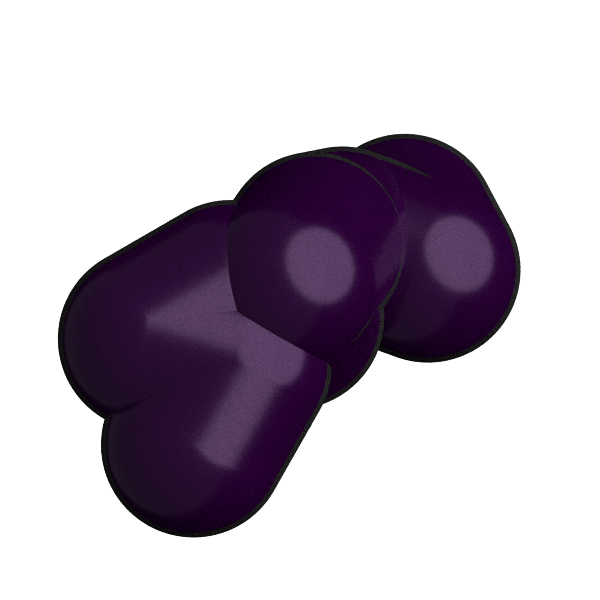

In [5]:
#visualize initialization
bonds = get_bonds(sim, chains=chains)
colors = compute_colors(monomer_positions, chains)
radii = np.full((monomer_positions.shape[0],), 1, dtype=np.float32)
backends.Fresnel(monomer_positions, bonds, colors, radii).static(pathtrace=True)

In [6]:
# run simulation
for _ in range(100):  # Do 10 blocks
    sim.do_block(1000)  # Of 100 timesteps each. Data is saved automatically.
sim.print_stats() 

EKExceedsError: Ek=17.862920716482886 exceeds 10

### Now try with collision rate = 1

In [7]:


Chromosome_sizes=[10]
chains = [(0,10,False)]
N=sum(Chromosome_sizes)
density=0.33

box_length = (N/density) ** (1/3.)
monomer_positions = create_random_walk(step_size=1,N=N)

#initialize simulation
#reporter = HDF5Reporter(folder="/trajectory/homopolymer_test", max_data_length=25, overwrite=True)

sim = simulation.Simulation(
    platform="CPU",
    integrator="variableLangevin",
    error_tol=0.01,
    #collision_rate=0.06,
    collision_rate=1,
    N=N,
    save_decimals=2,
    PBCbox=False,
    #reporters=[reporter],
    timestep=60 #femtoseconds
)

sim.set_data(monomer_positions, center=True) #loads positions, set center of mass to origin

#sim.add_force(forces.spherical_confinement(sim, density=0.85, k=1))
sim.add_force(forces.spherical_confinement(sim, k=3))

bonds = get_bonds(sim, chains=chains, extra_bonds=None)

bonds = [tuple(bond) for bond in bonds]

triplets = get_triplets(sim, chains=chains, extra_triplets=None)
triplets = [tuple(triplet) for triplet in triplets]

sim.add_force(forces.harmonic_bonds(sim, bondLength=1, bondWiggleDistance=0.05, bonds=bonds))
sim.add_force(forces.polynomial_repulsive(sim, trunc=3.0))
sim.add_force(forces.angle_force(sim,k=1.5,triplets=triplets))


#can also do this with forcekits

# Define the polymer chains first to get the bonds
# sim.add_force(
#     forcekits.polymer_chains(
#         sim,
#         chains=chains,
#         # By default the library assumes you have one polymer chain
#         # If you want to make it a ring, or more than one chain, use self.setChains
#         # self.setChains([(0,50,True),(50,None,False)]) will set a 50-monomer ring and a chain from 50 to the end
#         bond_force_func=forces.harmonic_bonds,
#         bond_force_kwargs={
#             "bondLength": 1.0,
#             "bondWiggleDistance": 0.05,  # Bond distance will fluctuate +- 0.05 on average
#         },
#         angle_force_func=forces.angle_force,
#         angle_force_kwargs={
#             "k": 1.5,
#             # K is more or less arbitrary, k=4 corresponds to presistence length of 4,
#             # k=1.5 is recommended to make polymer realistically flexible; k=8 is very stiff
#         },
#         # nonbonded_force_func=forces.polynomial_repulsive,
#         # nonbonded_force_kwargs={
#         #     "trunc": 3.0,  # this will let chains cross sometimes
#         #     # 'trunc':10.0, # this will resolve chain crossings and will not let chain cross anymore
#         # },
#         except_bonds=True,
#     )
# )


sim.local_energy_minimization(tolerance=0.1, maxIterations=1000)

INFO:root:Performing local energy minimization
INFO:root:adding force spherical_confinement 0
INFO:root:adding force harmonic_bonds 1
INFO:root:adding force polynomial_repulsive 2
INFO:root:adding force angle 3
INFO:root:Particles loaded. Potential energy is 1.131411
INFO:root:before minimization eK=1.2755298042555328, eP=1.1314108280981807, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.318604
INFO:root:after minimization eK=1.2755298042555328, eP=0.21500490820390544, time=0.0 ps


Setting up CPU platform with 4 threads
Before setting threads - Platform properties: ('Threads', 'DeterministicForces')
After setting threads - Platform properties: ('Threads', 'DeterministicForces')


In [8]:
# run simulation
for _ in range(100):  # Do 10 blocks
    sim.do_block(1000)  # Of 100 timesteps each. Data is saved automatically.
sim.print_stats() 

INFO:root:block    0 pos[1]=[0.0 0.8 -0.8] dr=1.56 t=117.4ps kin=1.41 pot=1.67 Rg=1.282 SPS=13873 dt=104.9fs dx=27.84pm 
INFO:root:block    1 pos[1]=[1.4 2.0 -0.8] dr=1.54 t=237.3ps kin=1.23 pot=2.35 Rg=1.602 SPS=15553 dt=114.7fs dx=28.46pm 
INFO:root:block    2 pos[1]=[0.0 1.0 -1.6] dr=1.13 t=353.8ps kin=1.73 pot=1.43 Rg=1.569 SPS=15458 dt=114.9fs dx=33.75pm 
INFO:root:block    3 pos[1]=[-0.9 0.6 -0.2] dr=1.49 t=467.2ps kin=1.29 pot=2.30 Rg=1.283 SPS=16325 dt=98.0fs dx=24.84pm 
INFO:root:block    4 pos[1]=[0.8 0.3 -0.7] dr=1.84 t=586.4ps kin=1.99 pot=1.38 Rg=1.261 SPS=16324 dt=113.7fs dx=35.80pm 
INFO:root:block    5 pos[1]=[1.9 1.8 -0.1] dr=2.12 t=700.6ps kin=2.31 pot=3.21 Rg=1.364 SPS=16559 dt=123.6fs dx=41.98pm 
INFO:root:block    6 pos[1]=[0.5 -0.2 -2.2] dr=2.31 t=817.9ps kin=0.80 pot=1.46 Rg=1.366 SPS=16163 dt=125.2fs dx=25.05pm 
INFO:root:block    7 pos[1]=[-0.1 -1.9 0.1] dr=1.88 t=932.4ps kin=1.95 pot=1.43 Rg=1.441 SPS=15302 dt=123.2fs dx=38.40pm 
INFO:root:block    8 pos[1]=[0


 Statistics: number of particles: 10

Statistics for particle position
     mean position is:  [-0.24384185 -0.1508242   0.36269999]   Rg =  1.6026561
     median bond size is  0.975098271940805
     three shortest/longest (<10)/ bonds are  [0.94546066 0.95056918 0.96263095]    [1.0168155  1.01766468 1.01972916]
     95 percentile of distance to center is:    2.2236054456068035
     density of closest 95% monomers is:    0.20628222593990908
     density of the 5% closest to CoM monomers is:    0.09176309790034852
     min/median/mean/max coordinates are: 
     x: -2.04, -0.19, -0.24, 1.74
     y: -0.92, -0.28, -0.15, 0.67
     z: -0.96, 0.48, 0.36, 1.55

Statistics for velocities:
     mean kinetic energy is:  1.6892016881329905 should be: 1.5
     fastest particles are (in kT):  [1.27031071 2.57173516 2.89572367 2.95278937 3.7715729 ]

Statistics for the system:
     Forces are:  ['spherical_confinement', 'harmonic_bonds', 'polynomial_repulsive', 'angle']

Potential Energy Ep =  1.43

/var/folders/8x/ydyynnlj6qb3n3b3bs1wqlt40000gn/T/ipykernel_76647/616869719.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap(cmap)


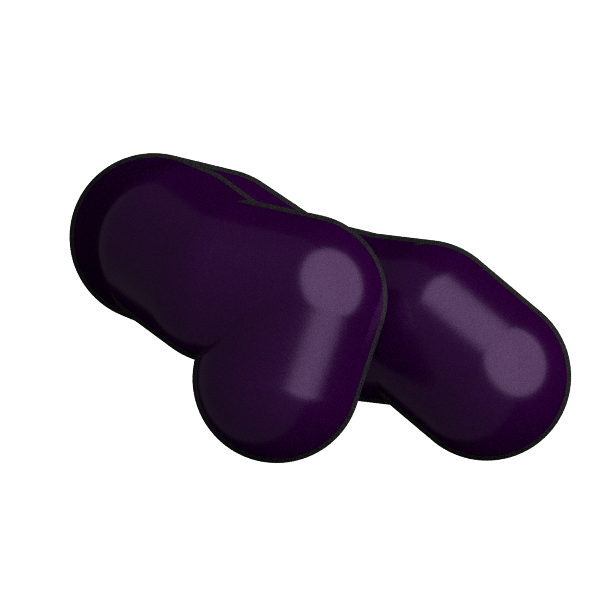

In [10]:
#visualize output
#visualize initialization
updated_positions = sim.get_data()
bonds = get_bonds(sim, chains=chains)
colors = compute_colors(monomer_positions, chains)
radii = np.full((monomer_positions.shape[0],), 1, dtype=np.float32)
backends.Fresnel(updated_positions, bonds, colors, radii).static(pathtrace=True)